In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 北京資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京3.xls')
df4 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京4.xls')
df5 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京5.xls')
df6 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京6.xls')
df7 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京7.xls')
df8 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京8.xls')
df9 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京9.xls')
df10 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京10.xls')
df11 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-北京11.xls')

patent_df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11],ignore_index=True,sort=True)

In [35]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'11\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

In [4]:
incoPat = list(patent_df_firm['申请人'])

In [5]:
patent_df_firm.shape

(13677, 38)

In [6]:
firm_gd.shape

(3321, 6)

In [10]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [11]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\北京_廠商.xlsx')

# 非模糊比對

In [10]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(855, 44)
(11956, 44)


In [11]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(8717, 49)
(11956, 49)


# merge舊資料

In [36]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(765, 44)
(9410, 44)
(6650, 49)
(9410, 49)


In [37]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\北京_結果.xlsx')

In [38]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','中關村','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(2926, 53)

In [39]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\北京_結果.xlsx')

# 模糊比對

In [15]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

(1249, 45)
(15737, 45)


In [16]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

(11583, 50)
(13309, 50)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\北京_模糊結果.xlsx')

# 定位

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\北京_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\北京_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(2926, 53)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(9410, 53)
(71, 53)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\北京_結果.xlsx')

# 作圖

In [7]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [8]:
patent_count.sort_values()

申请人2
玉林                  1
史长胜                  1
史长虹                  1
王亚明                  1
王亚利                  1
                 ...  
联想(北京)有限公司        8050
中国石油天然气股份有限公司    11217
清华大学             16291
中国石油化工股份有限公司     21686
国家电网公司           30927
Name: 專利數, Length: 80446, dtype: int64

In [87]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\北京_結果.xlsx',index_col=0)
target1 = (39.97864,116.36812)
merge_df['中關村'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [9]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\北京_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (39.97864,116.36812)

for i in merge_df[merge_df['中關村']==''].index:
    merge_df.loc[i,'中關村'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if (x['中關村']<10) else 0,axis=1)
merge_df['近期園區'] = 0

In [11]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\北京_結果.xlsx')

In [12]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(9410, 53)
0.20478214665249733
0.026886291179596174


In [13]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0        1927
1.0        1621
2.0         999
3.0         597
4.0         495
5.0         360
6.0         342
7.0         285
8.0         257
9.0         216
10.0        187
11.0        171
12.0        126
13.0         95
14.0        119
15.0        102
16.0         94
17.0         74
18.0         62
19.0         64
20.0         57
21.0         46
22.0         47
23.0         31
24.0         30
25.0         36
26.0         25
27.0         35
28.0         39
29.0         33
30.0         36
31.0         26
32.0         29
33.0         20
34.0         22
35.0         24
36.0         20
37.0         20
38.0         15
39.0          5
40.0         16
41.0         14
42.0         13
43.0         15
44.0         17
45.0          8
46.0         16
47.0         15
48.0         16
49.0          9
50.0         14
51.0         13
52.0          7
53.0          5
54.0          3
55.0         10
56.0          6
57.0         13
58.0          6
59.0          3
60.0          6
61.0          5
62.0

In [14]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0     23
1.0     11
2.0      7
3.0      8
4.0      2
5.0      2
6.0      1
7.0      4
9.0      2
10.0     1
11.0     1
14.0     2
17.0     1
24.0     1
28.0     2
29.0     1
30.0     1
34.0     1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

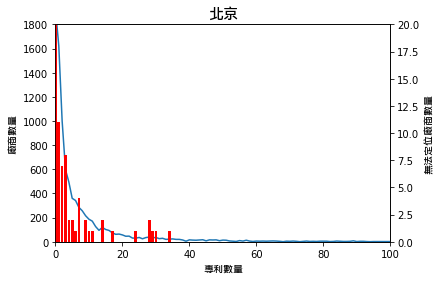

In [15]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('北京',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,1800])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [9]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\北京_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','公司','责任','集团','股份','控股','总公司','分公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

5869
0.6406505839973802
158


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1        1452
2         868
3         503
4         417
5         292
6         265
7         225
8         189
9         169
10        129
11        124
12         79
13         61
14         75
15         67
16         63
17         47
18         41
19         40
20         40
21         28
22         27
23         20
24         21
25         24
26         18
27         21
28         24
29         18
30         22
31         11
32         15
33         13
34         14
35         16
36         15
37         16
38         13
39          3
40          9
41          6
42         10
43          9
44          6
45          5
46         10
47         10
48          9
49          7
50          9
51          8
52          6
53          3
54          1
55          5
56          4
57          5
58          4
59          4
60          5
61          2
62          4
63          5
64          6
65          4
66          4
67          4
69          2
70          3
71          3
72          2
75

In [4]:
not_merge[not_merge['專利數']>=1000].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,标准化申请人,标题,申请人国别代码,申请人地址,申请人省市代码,申请人类型,申请号,申请日,简单同族,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,中關村,早期園區,近期園區,專利數,name_clean
8440,,,,,,,,H04N21/422; G08C17/02; G08C23/04,CN103813189B; CN103813189A,2,,发明授权,[朝阳],[北京],,CN,CN103813189B,2018-09-07 00:00:00,杨飞,9,CN,,8625,CN101719998A; CN102208130A; CN102665124A; CN102098461A,,...,[乐金集团-C],一种遥控机顶盒的方法及系统,中国,北京市朝阳区望京利泽中园二区203号洛娃大厦B座,北京; 11,企业,CN201210450235.1,2012-11-12 00:00:00,CN103813189A; CN103813189B,2,,,0,到incoPat中查看\r\nCN103813189B,乐金电子(中国)研究开发中心有限公司,乐金电子(中国)研究开发中心有限公司,北京市朝阳区望京利泽中园二区203号洛娃大厦B座,0,40.0131,116.472,9.693926,1,0,1040,乐金电子研究开发中心
8738,,,,,,,,C25B1/00; C01G15/00,CN102978649B; CN102978649A,2,0,发明授权,[海淀],[北京],,CN,CN102978649B,2015-03-25 00:00:00,孙剑锋; 刘彩玫; 管督; 常晖,9,CN,,34491,CN101249983A,"<text>佘旭.高纯镓电解精炼的研究.《稀有金属》.2007, 第31卷(第6期), 全文.</text><text>马太琼.99.99999%高纯镓的制备工艺.《稀有金属》.1979, (第5期), (三)镓的电解精炼提纯.</text><text>苏毅等.高纯金属镓制备技术研究进展.《稀有金属》.2003, 第27卷(第4期), 1.1电解精制法.</text>",...,[中国铝业-C],一种高纯氧化镓的制备方法,中国,北京市海淀区西直门北大街62号,北京; 11,企业,CN201210542115.4,2012-12-14 00:00:00,CN102978649B; CN102978649A,2,,,0,到incoPat中查看\r\nCN102978649B,中国铝业股份有限公司,中国铝业股份有限公司,北京市海淀区西直门北大街62号,1,39.9452,116.358,3.812119,1,0,1308,中国铝业
8961,,,,,,,,C10L9/00; C10L9/08; F26B23/08,CN103074140A; CN103074140B,2,,发明授权,[东城],[北京],,CN,CN103074140B,2014-10-29 00:00:00,赵剑; 孙伟彪; 李根英; 包正强; 张永桂; 刘超; 田惠生; 郑玉虎; 陈磊; 姚腾; 马春元; 宋占龙; 赵希强,9,CN,,5175,,,...,[神华集团-C],一种煤炭除杂系统,中国,北京市东城区安外西滨河路神华大厦,北京; 11,企业,CN201210589785.1,2012-12-28 00:00:00,CN103074140A; CN103074140B,2,,,0,到incoPat中查看\r\nCN103074140B,神华集团有限责任公司,神华集团有限责任公司,北京市东城区安外西滨河路神华大厦,0,39.9498,116.399,4.150960,1,0,1328,神华
8953,,,,,,,,G06F9/445,CN103077050B; CN103077050A,2,,发明授权,[海淀],[北京],,CN,CN103077050B,2016-09-21 00:00:00,林锦滨; 汪轩然; 林形省; 马坤; 武小军,9,CN,,21833,CN102646037A; CN101727279A; US20080021876A1,,...,[小米科技-c],一种显示应用程序信息的方法、装置及设备,中国,北京市海淀区清河中街68号华润五彩城购物中心二期13层,北京; 11,企业,CN201210587267.6,2012-12-28 00:00:00,CN103077050A; CN103077050B,2,,,0,到incoPat中查看\r\nCN103077050B,小米科技有限责任公司,小米科技有限责任公司,北京市海淀区清河中街68号华润五彩城购物中心二期13层,1,40.0305,116.333,6.502846,1,0,1386,小米科技
7031,,,,,,,,G06F9/46; G06F1/32,CN102495756A; CN102495756B,2,,发明授权,[海淀],[北京],,CN,CN102495756B,2016-09-14 00:00:00,杨磊; 孔英奇; 赵艳,10,CN,,22515,CN101937363A; CN1694086A; US20090222654A1; CN101598968A,,...,,操作系统在不同的中央处理器之间切换的方法及系统,中国,北京市海淀区学院路35号世宁大厦15层,北京; 11,企业,CN201110349133.6,2011-11-07 00:00:00,CN102495756A; CN102495756B,2,,,0,到incoPat中查看\r\nCN102495756B,北京中星微电子有限公司,北京中星微电子有限公司,北京市海淀区学院路35号世宁大厦15层,1,39.9857,116.352,1.575599,1,0,1390,北京中星微电子
9009,,,,,,,,H04W8/24; H04W76/02,CN103139760B; CN103139760A,2,0,发明授权,[西城],[北京],,CN,CN103139760B,2015-09-16 00:00:00,蒋泽民; 任恒勃; 张远文,9,CN,,6245,CN101605322A; CN102149083A; CN102480720A; CN102802148A,,...,[中国联通-C],写卡处理方法和装置,中国,北京市西城区金融大街21号,北京; 11,企业,CN201210593759.6,2012-12-31 00:00:00,CN103139760A; CN103139760B,2,,,0,到incoPat中查看\r\nCN103139760B,中国联合网络通信集团有限公司,中国联合网络通信集团有限公司,北京市西城区金融大街21号,1,39.9146,116.358,7.162521,1,0,1401,中国联合网络通信
9040,,,,,,,,G06F17/30,CN103064967A; CN103064967B,2,,发明授权,[海淀],[北京],,CN,CN103064967B,2018-10-12 00:00:00,陆阳阳; 孟可丰,8,CN,,7496,CN101114298A; CN101290632A; CN101013443A; US20120089907A1,,...,[百度公司-C],一种用于建立用户二元关系库的方法与设备,中国,北京市海淀区上地十街10号百度大厦,北京; 11,企业,CN201210592849.3,2012-12-31 00:00:00,CN103064967B; CN103064967A,2,,,0,到incoPat中查看\r\nCN103064967B,百度在线网络技术(北京)有限公司,百度在线网络技术(北京)有限公司,北京市海淀区上地十街10号百度大厦,1,40.051,116.301,9.875034,1,0,1625,百度在线网络技术
8986,,,,,,,,G06F17/30,CN103902625A; CN103902625B,2,,发明授权,[海淀],[北京],,CN,CN103902625B,2018-08-07 00:00:00,任艳方,7,CN,,9981,CN102467074A; KR101134825B1,"<text>雨中漫步.关于维度中的属性及命名计算.《http : //blog.sina.com.cn/s/blog_ 4cd320930100cx89.html》.2009, 第1-5页.</text><text>王学科.基于.NET的桌面提醒软件的设计与实现.《中国优秀硕士学位论文全文数据库 信息科技辑》.2012, I138-216第20-31页.</text>",...,[北大方正-C],一种确定时间维度表数据的方法及装置,中国,北京市海淀区成府路298号方正大厦9层,北京; 11,企业,CN201210587732.6,2012-12-28 00:00:00,CN103902625A; CN

Text(0.5, 0, '專利數量')

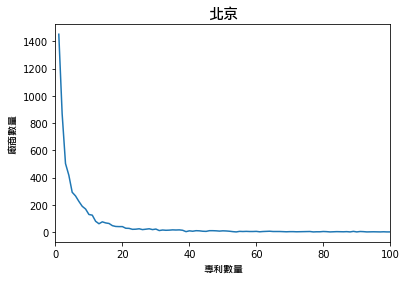

In [6]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('北京',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [7]:
cleaned.to_excel(r'E:\paper\名稱merge\北京_結果.xlsx')

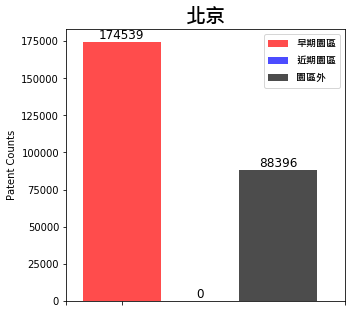

In [108]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum()+100, '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum()+100, '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()+100, '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('北京',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


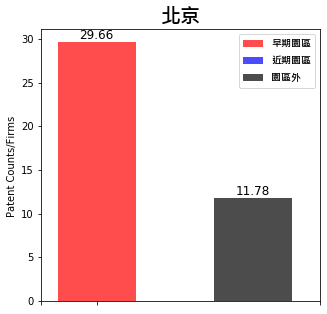

In [137]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.2f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('北京',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)